In [1]:
exp_odir = 'output/echam-6.3.05p2-wiso/pi/'
expid = [
    'pi_m_502_5.0',
    ]
i = 0

# import packages

In [2]:
# -----------------------------------------------------------------------------
# region import packages

# management
import glob
import pickle
import warnings
warnings.filterwarnings('ignore')
import os
import sys  # print(sys.path)
sys.path.append('/work/ollie/qigao001')
os.chdir('/work/ollie/qigao001')
# data analysis
import numpy as np
import xarray as xr
import dask
dask.config.set({"array.slicing.split_large_chunks": True})
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()
from scipy import stats
import xesmf as xe
import pandas as pd
from metpy.interpolate import cross_section
from statsmodels.stats import multitest
import pycircstat as circ
import xskillscore as xs

# plot
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib import cm
import cartopy.crs as ccrs
plt.rcParams['pcolor.shading'] = 'auto'
mpl.rcParams['figure.dpi'] = 600
mpl.rc('font', family='Times New Roman', size=10)
mpl.rcParams['axes.linewidth'] = 0.2
plt.rcParams.update({"mathtext.fontset": "stix"})
import matplotlib.animation as animation
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator

# self defined
from a_basic_analysis.b_module.mapplot import (
    globe_plot,
    hemisphere_plot,
    quick_var_plot,
    mesh2plot,
    framework_plot1,
    remove_trailing_zero,
    remove_trailing_zero_pos,
)

from a_basic_analysis.b_module.basic_calculations import (
    mon_sea_ann,
    find_nearest_1d,
    get_mon_sam,
)

from a_basic_analysis.b_module.namelist import (
    month,
    month_num,
    month_dec,
    month_dec_num,
    seasons,
    seasons_last_num,
    hours,
    months,
    month_days,
    zerok,
    panel_labels,
    seconds_per_d,
)

from a_basic_analysis.b_module.source_properties import (
    source_properties,
    calc_lon_diff,
)

from a_basic_analysis.b_module.statistics import (
    fdr_control_bh,
    check_normality_3d,
    check_equal_variance_3d,
    ttest_fdr_control,
)

from a_basic_analysis.b_module.component_plot import (
    cplot_ice_cores,
    plt_mesh_pars,
)

# endregion
# -----------------------------------------------------------------------------


# import data

In [3]:
sam_mon = xr.open_dataset(exp_odir + expid[i] + '/analysis/echam/' + expid[i] + '.sam_mon.nc')

sam_marshall = pd.read_csv(
    'data_sources/climate_indices/SAM/SAM.txt', sep = '\s+',
    index_col=0)


# Comparison of SAM

## mean

In [5]:
print(sam_mon.sam.mean().values)
# 1971 - 2000
print(sam_marshall.iloc[14:44].to_numpy().flatten().mean())

2.7020773e-08
-0.000111111111111089


## Std

In [6]:
print(sam_mon.sam.std(ddof = 1).values)
print(sam_marshall.iloc[14:44].to_numpy().flatten().std(ddof = 1))

1.8827093839645386
1.7379289980044097


## Trend

In [7]:
import pymannkendall as mk

print(mk.original_test(sam_mon.sam))

# 1971 - 2000
print(mk.original_test(sam_marshall.iloc[14:44].to_numpy().flatten()))

# 2001 - 2022
print(mk.original_test(sam_marshall.iloc[44:66].to_numpy().flatten()))

Mann_Kendall_Test(trend='no trend', h=False, p=0.45741703349282137, z=0.7431067827366775, Tau=0.02028937117417919, s=3646.0, var_s=24059833.333333332, slope=0.00033635660043333673, intercept=0.1502642996383019)
Mann_Kendall_Test(trend='increasing', h=True, p=0.00028147889700447237, z=3.6317746271885762, Tau=0.12824203033116682, s=8287.0, var_s=5205375.666666667, slope=0.003367017114082543, intercept=-0.5693795719778164)
Mann_Kendall_Test(trend='increasing', h=True, p=0.03807519686439953, z=2.0740442993495565, Tau=0.08585609380895713, s=2958.0, var_s=2032668.6666666667, slope=0.003098591549295774, intercept=0.22408450704225358)


## Annual cycle

In [8]:
print(sam_mon.sam.groupby('time.month').mean().values)

print(sam_marshall.iloc[14:44].values.mean(axis=0))


[ 1.5734196e-04 -6.6173074e-05  2.0022393e-05 -1.4266372e-05
  6.6709517e-06 -6.5795779e-05  5.9477090e-05 -1.0204316e-06
 -1.2464523e-04 -4.4348388e-05  3.5324098e-05  3.7851332e-05]
[-3.33333333e-04 -3.33333333e-04  6.66666667e-04  6.66666667e-04
 -1.00000000e-03  1.66533454e-17 -7.40148683e-18  6.66133815e-17
  2.96059473e-17 -7.40148683e-17 -1.00000000e-03 -2.96059473e-17]


## sam+ seasonality, no

In [4]:
(sam_mon.sam > sam_mon.sam.std(ddof = 1)).groupby('time.month').sum().values


array([ 7,  6,  8,  5,  8,  7, 10, 11,  8,  7,  7, 10])

## sam- seasonality, no

In [10]:
(sam_mon.sam < (-1 * sam_mon.sam.std(ddof = 1))).groupby('time.month').sum().values

array([ 8,  7,  9, 10,  8,  7,  9,  9,  8,  8,  7, 11])

## plot

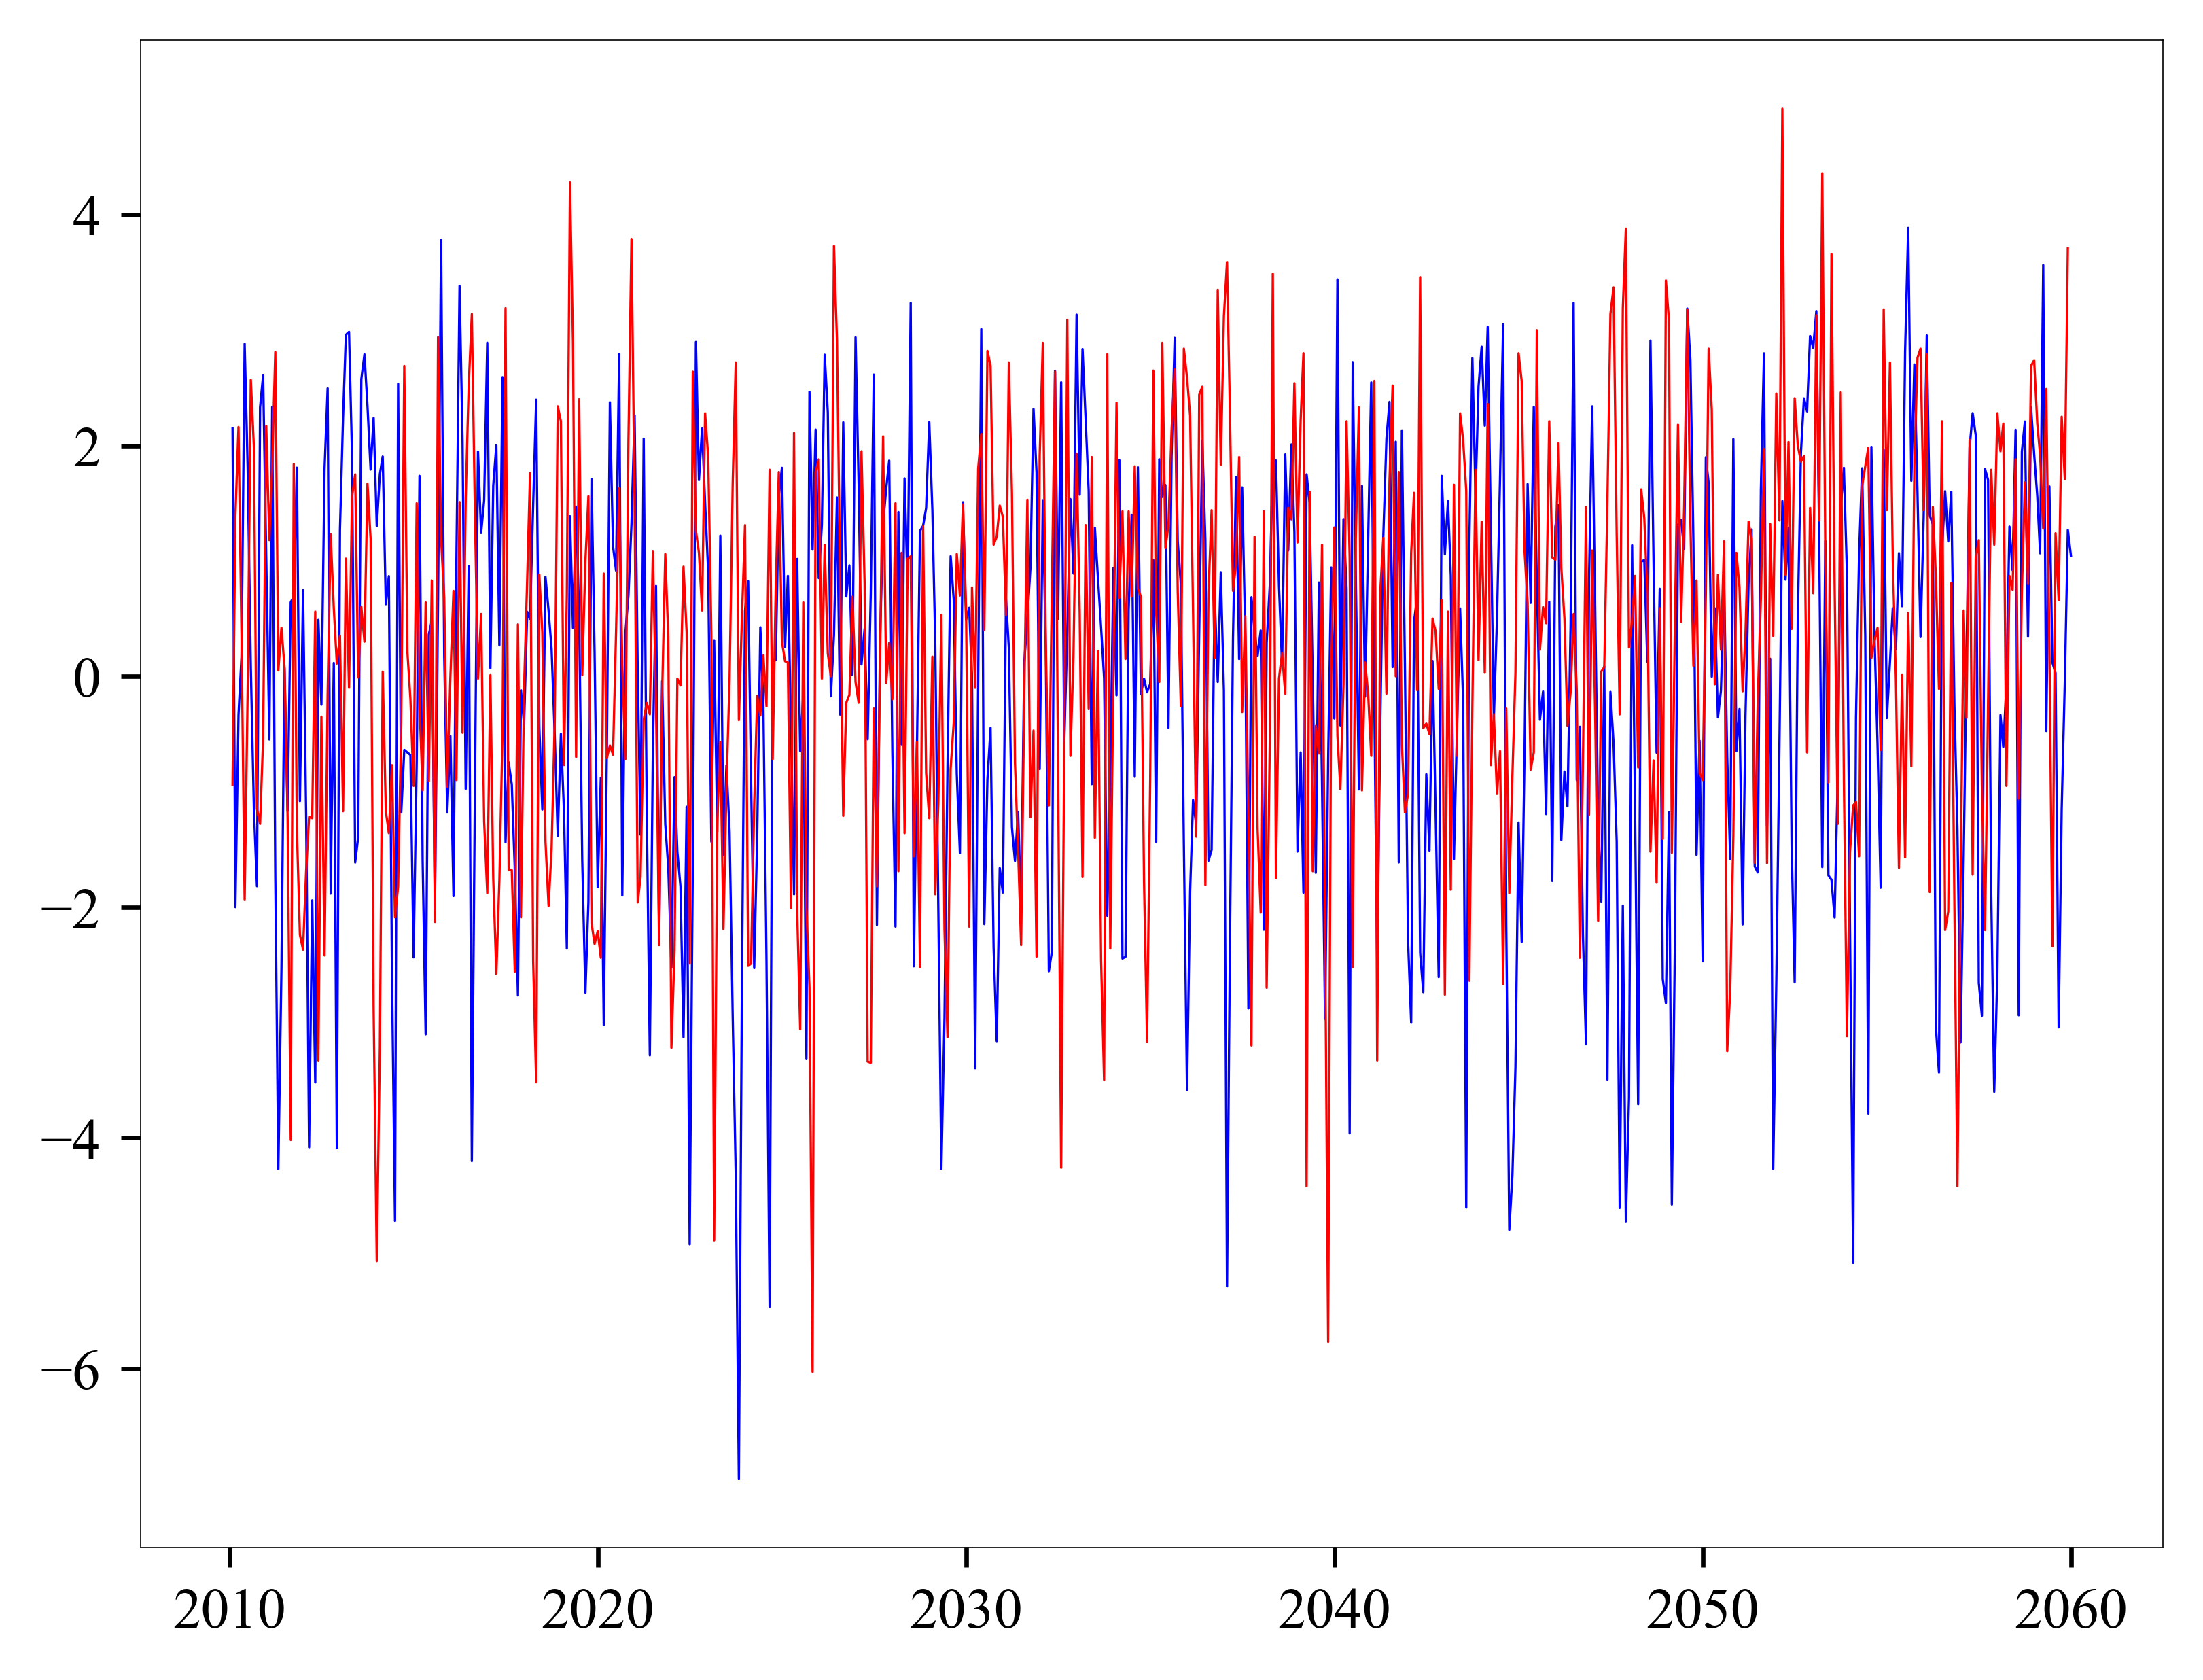

In [12]:
plt.plot(sam_mon.sam.time, sam_mon.sam, color = 'b', lw = 0.4)
plt.plot(sam_mon.sam.time,
         sam_marshall.iloc[16:66].to_numpy().flatten(), color = 'r', lw = 0.4)

# Compare 40° S and 65° S MSLP

## import data

In [4]:
psl_zh = {}
with open(exp_odir + expid[i] + '/analysis/echam/' + expid[i] + '.psl_zh.pkl', 'rb') as f:
    psl_zh[expid[i]] = pickle.load(f)


In [5]:
with open('scratch/cmip6/hist/psl/psl_era5_79_21_alltime.pkl', 'rb') as f:
    psl_era5_79_21_alltime = pickle.load(f)

## plot

### monthly

In [9]:
mon_psl = {}
mon_psl['sim_-40'] = psl_zh[expid[i]]['psl']['mon'].sel(lat=-40, method='nearest').mean(dim='lon').compute()
mon_psl['sim_-65'] = psl_zh[expid[i]]['psl']['mon'].sel(lat=-65, method='nearest').mean(dim='lon').compute()

mon_psl['era5_-40'] = psl_era5_79_21_alltime['mon'].sel(latitude=-40, method='nearest').mean(dim='longitude').compute()
mon_psl['era5_-65'] = psl_era5_79_21_alltime['mon'].sel(latitude=-65, method='nearest').mean(dim='longitude').compute()

[########################################] | 100% Completed | 15.93 s
[########################################] | 100% Completed | 7.76 ss


<AxesSubplot:xlabel='time', ylabel='psl'>

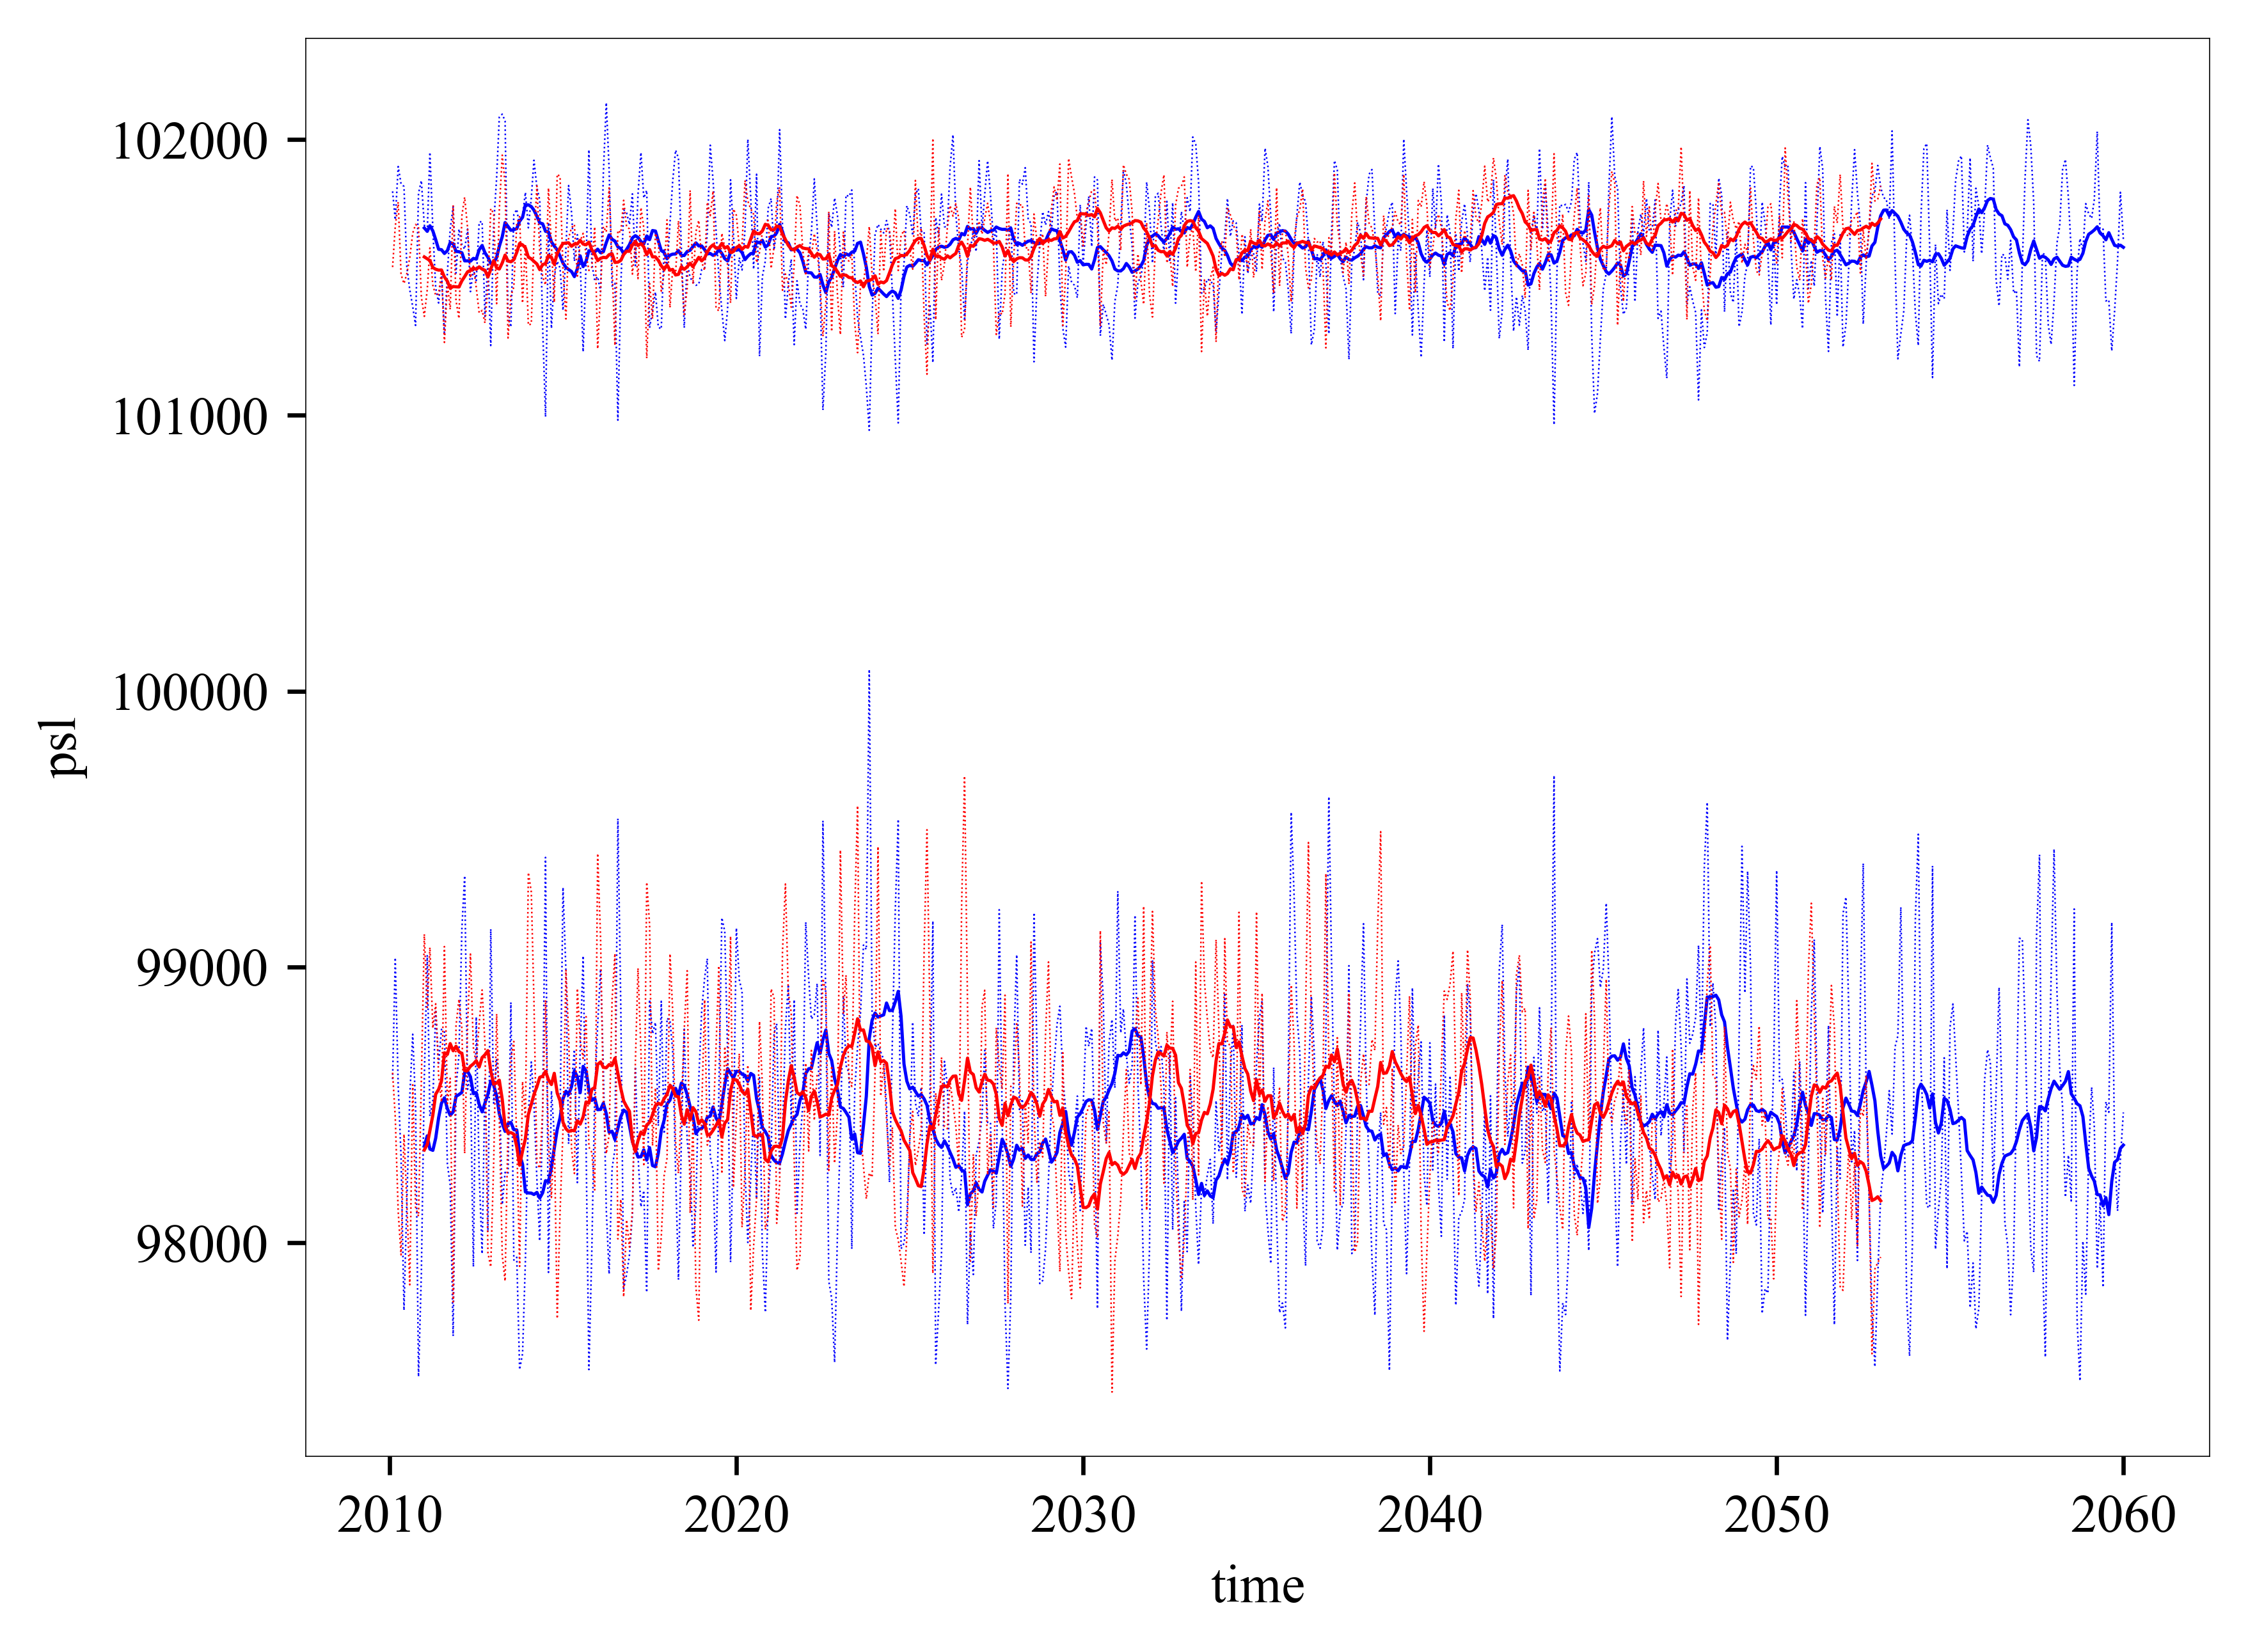

In [7]:
sns.lineplot(
    x = psl_zh[expid[i]]['psl']['mon'].time,
    y = mon_psl['sim_-40'],
    color='b', linewidth = 0.3, linestyle='dotted',)
sns.lineplot(
    x = psl_zh[expid[i]]['psl']['mon'].time,
    y = mon_psl['sim_-40'].to_dataframe().psl.rolling(window=12).mean(),
    color='b', linewidth = 0.6,)

sns.lineplot(
    x = psl_zh[expid[i]]['psl']['mon'].time,
    y = mon_psl['sim_-65'],
    color='b', linewidth = 0.3, linestyle='dotted',)
sns.lineplot(
    x = psl_zh[expid[i]]['psl']['mon'].time,
    y = mon_psl['sim_-65'].to_dataframe().psl.rolling(window=12).mean(),
    color='b', linewidth = 0.6,)

sns.lineplot(
    x = psl_zh[expid[i]]['psl']['mon'].time[:516],
    y = mon_psl['era5_-40'],
    color='r', linewidth = 0.3, linestyle='dotted',)
sns.lineplot(
    x = psl_zh[expid[i]]['psl']['mon'].time[:516],
    y = mon_psl['era5_-40'].to_dataframe().msl.rolling(window=12).mean(),
    color='r', linewidth = 0.6,)

sns.lineplot(
    x = psl_zh[expid[i]]['psl']['mon'].time[:516],
    y = mon_psl['era5_-65'],
    color='r', linewidth = 0.3, linestyle='dotted',)
sns.lineplot(
    x = psl_zh[expid[i]]['psl']['mon'].time[:516],
    y = mon_psl['era5_-65'].to_dataframe().msl.rolling(window=12).mean(),
    color='r', linewidth = 0.6,)


<AxesSubplot:xlabel='time', ylabel='psl'>

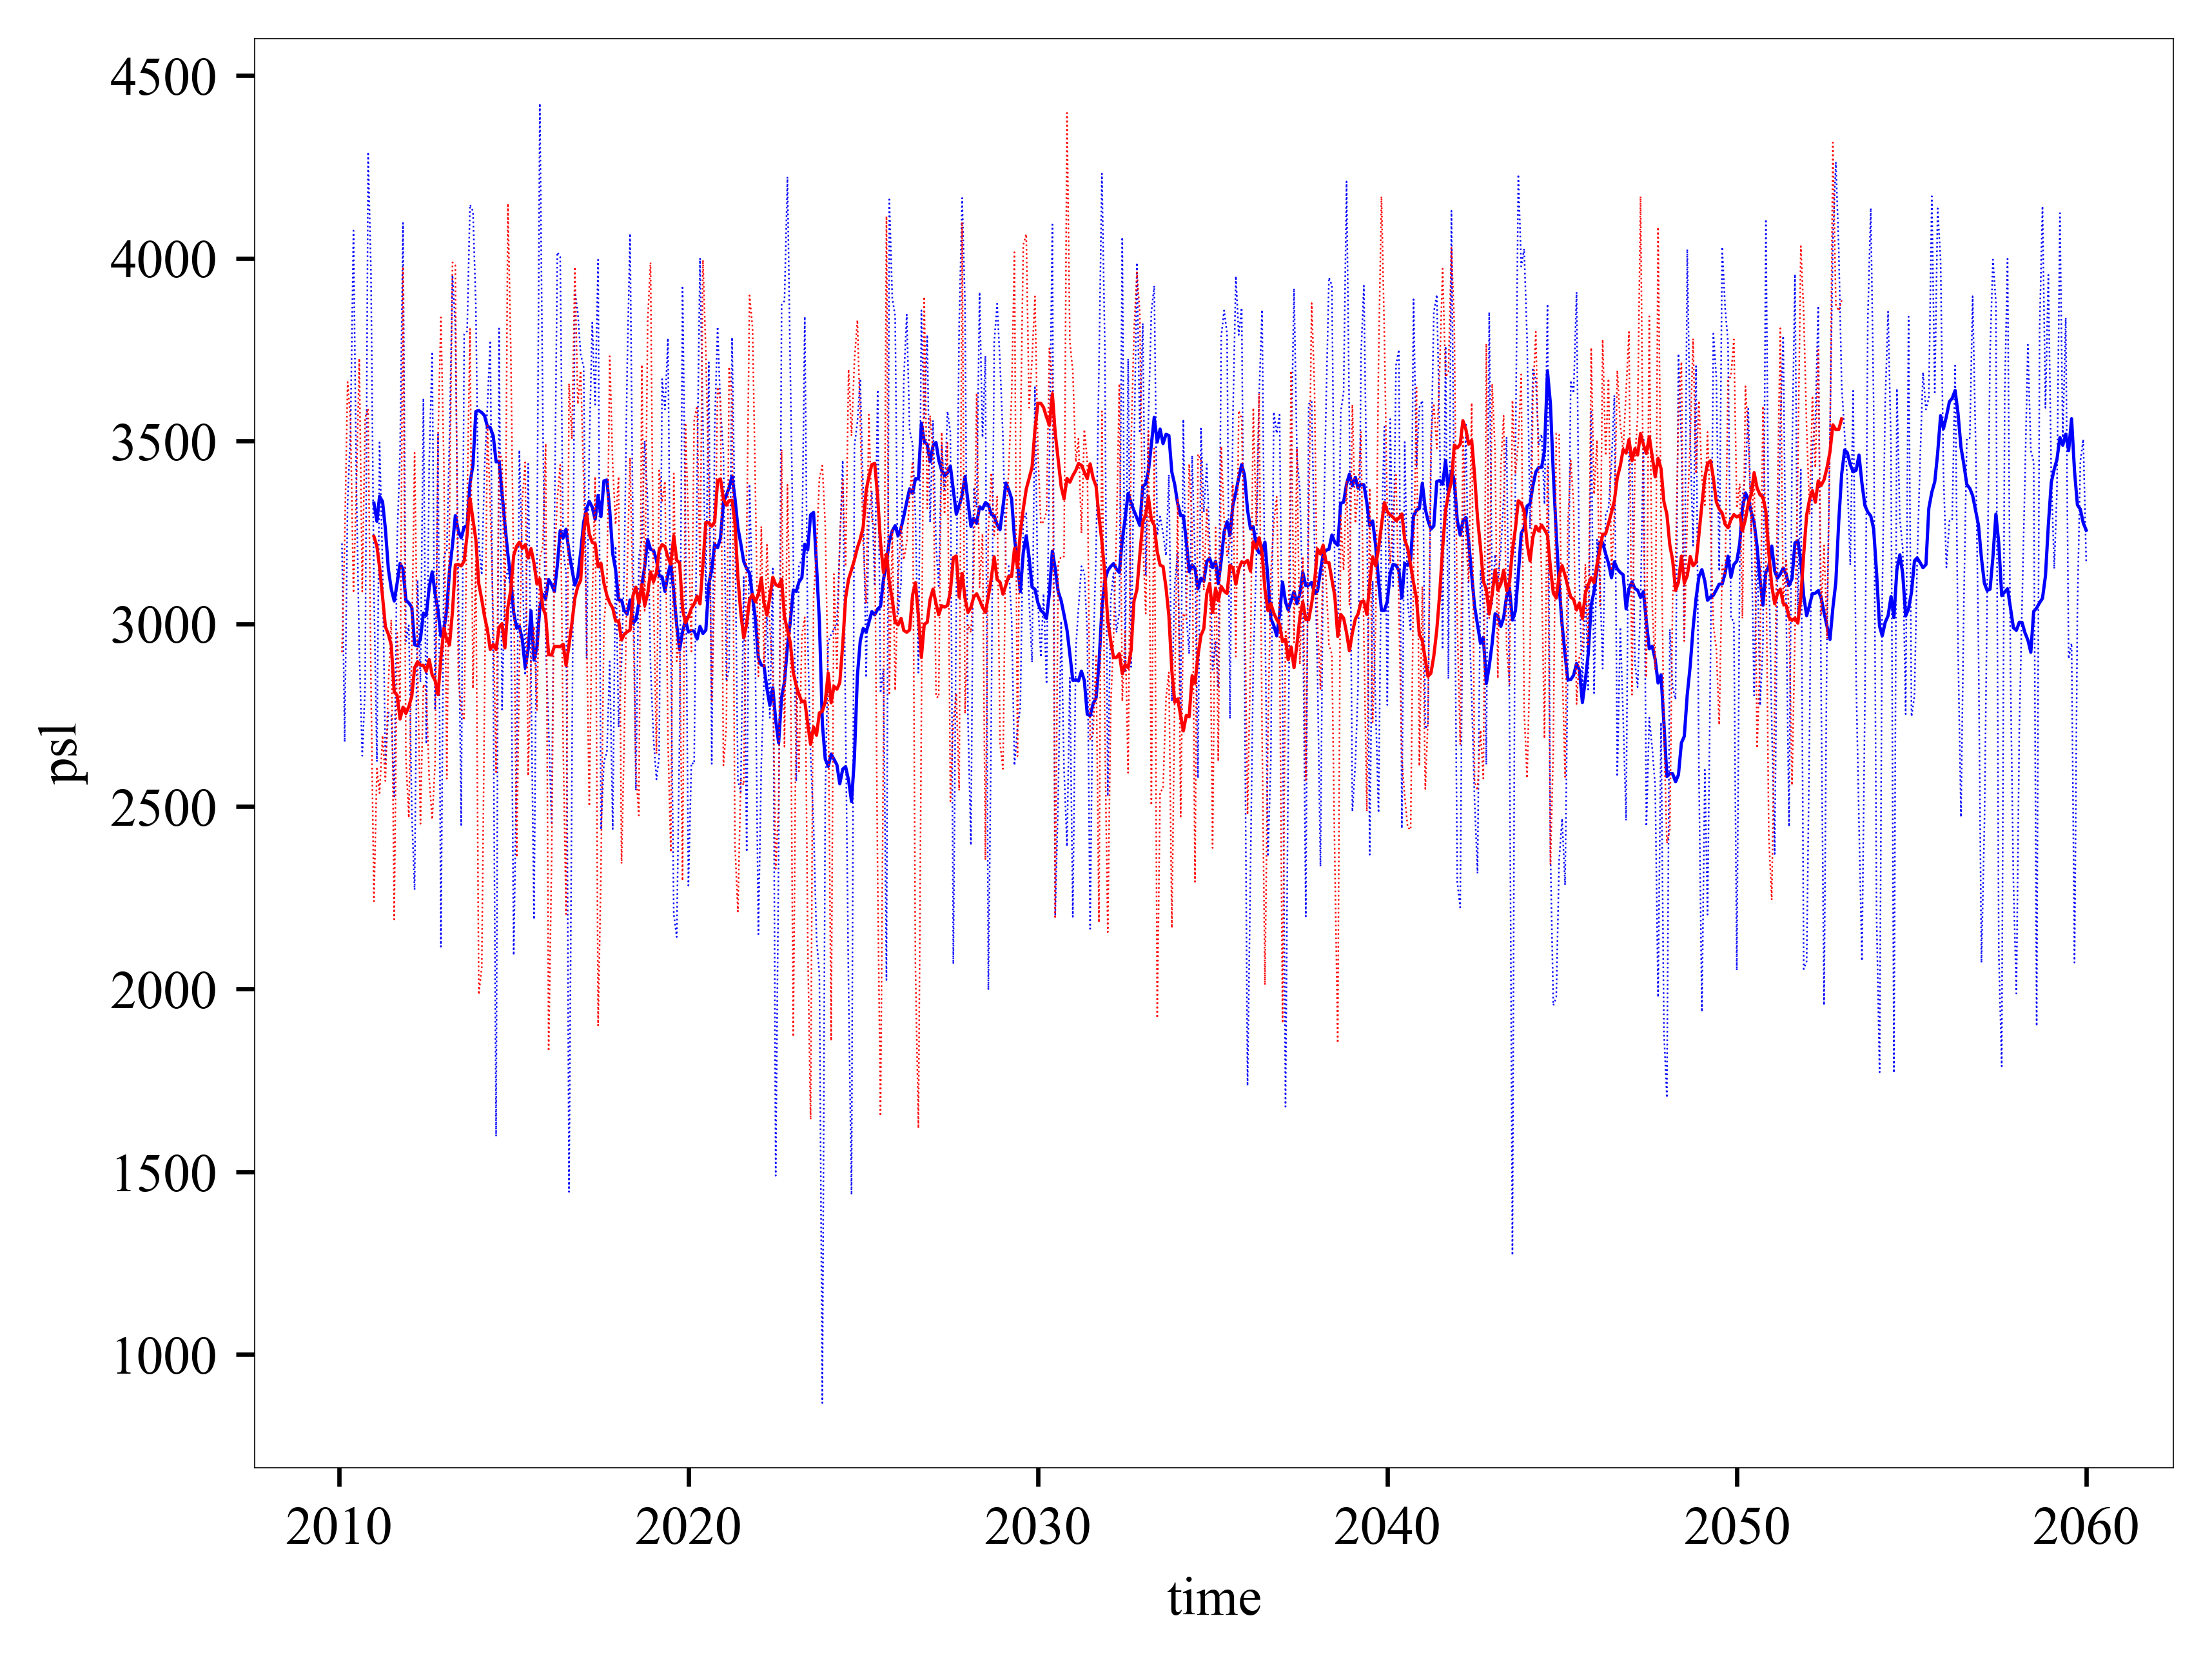

In [8]:
sns.lineplot(
    x = psl_zh[expid[i]]['psl']['mon'].time,
    y = mon_psl['sim_-40'] - mon_psl['sim_-65'],
    color='b', linewidth = 0.3, linestyle='dotted',)
sns.lineplot(
    x = psl_zh[expid[i]]['psl']['mon'].time,
    y = (mon_psl['sim_-40'] - mon_psl['sim_-65']).to_dataframe().psl.rolling(window=12).mean(),
    color='b', linewidth = 0.6,)

sns.lineplot(
    x = psl_zh[expid[i]]['psl']['mon'].time[:516],
    y = mon_psl['era5_-40'] - mon_psl['era5_-65'],
    color='r', linewidth = 0.3, linestyle='dotted',)
sns.lineplot(
    x = psl_zh[expid[i]]['psl']['mon'].time[:516],
    y = (mon_psl['era5_-40'] - mon_psl['era5_-65']).to_dataframe().msl.rolling(window=12).mean(),
    color='r', linewidth = 0.6,)

### monthly mean

In [7]:
mm_psl = {}
mm_psl['sim_-40'] = psl_zh[expid[i]]['psl']['mm'].sel(lat=-40, method='nearest').mean(dim='lon').compute()
mm_psl['sim_-65'] = psl_zh[expid[i]]['psl']['mm'].sel(lat=-65, method='nearest').mean(dim='lon').compute()

mm_psl['era5_-40'] = psl_era5_79_21_alltime['mm'].sel(latitude=-40, method='nearest').mean(dim='longitude').compute()
mm_psl['era5_-65'] = psl_era5_79_21_alltime['mm'].sel(latitude=-65, method='nearest').mean(dim='longitude').compute()


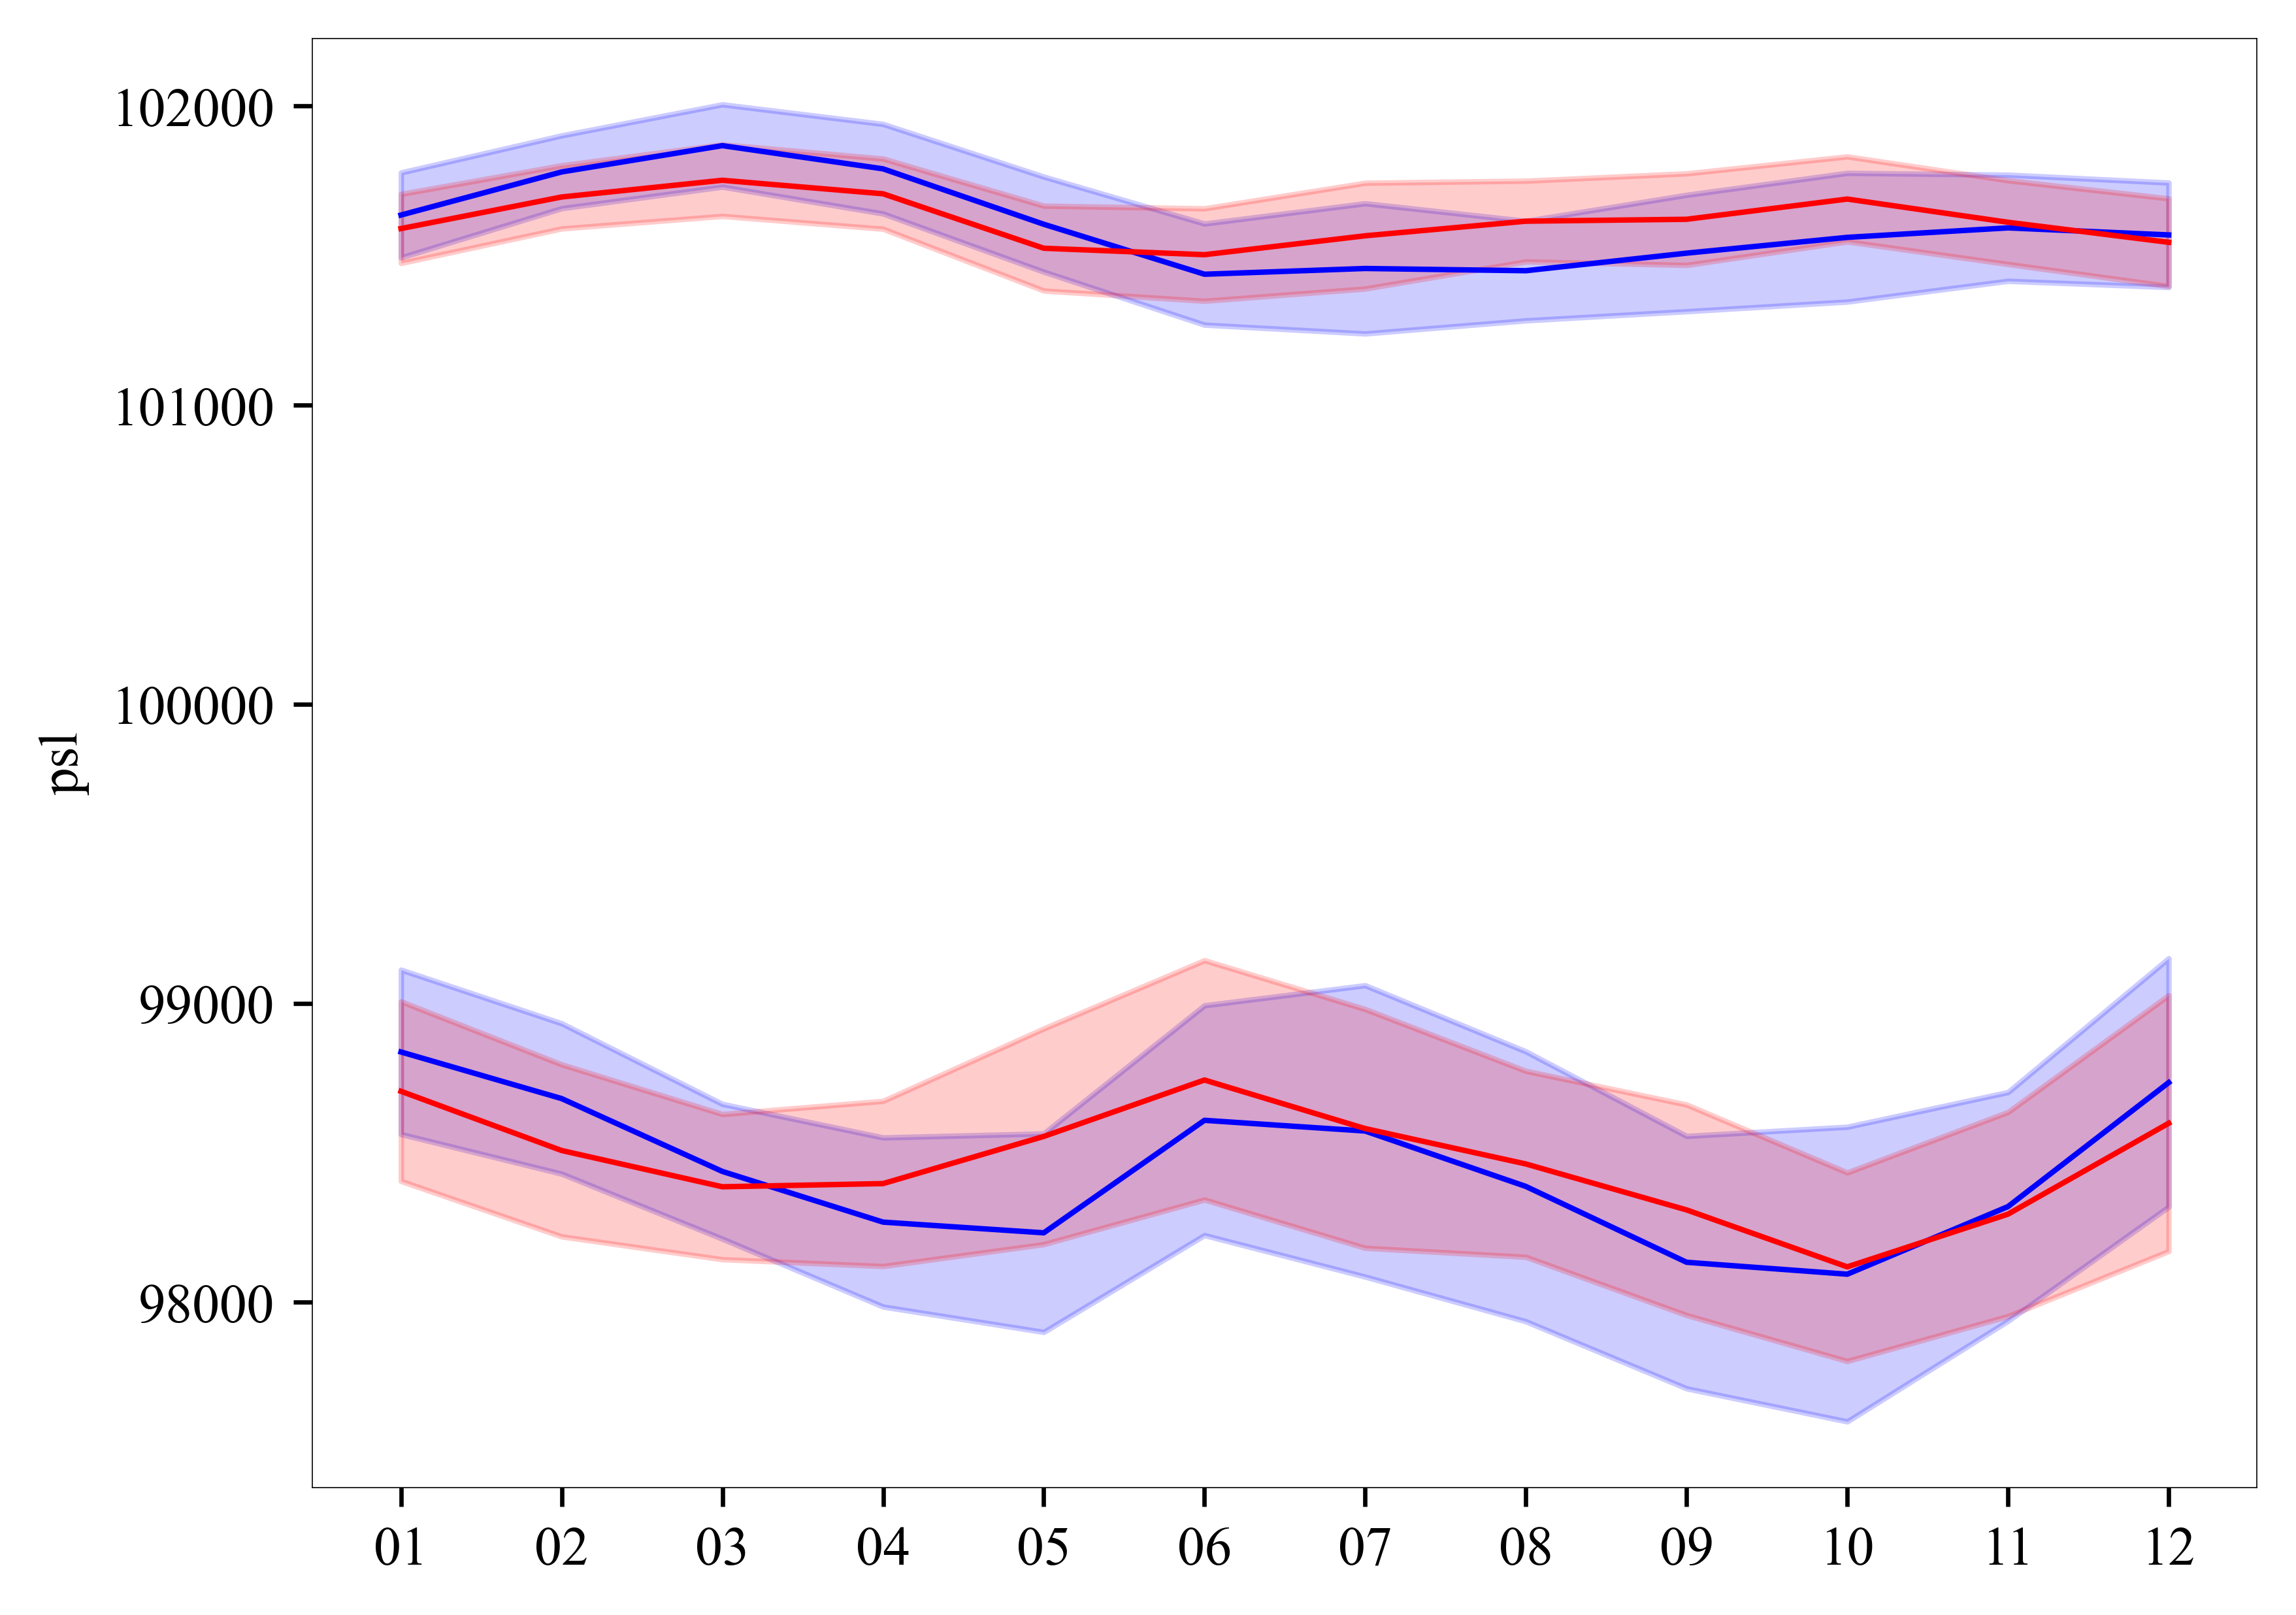

In [14]:

ax = sns.lineplot(
    x = months,
    y = mm_psl['sim_-40'],
    color='b', linewidth = 1,
)

sns.lineplot(
    x = months,
    y = mm_psl['sim_-65'],
    color='b', linewidth = 1,
)

sns.lineplot(
    x = months,
    y = mm_psl['era5_-40'],
    color='r', linewidth = 1,
)

sns.lineplot(
    x = months,
    y = mm_psl['era5_-65'],
    color='r', linewidth = 1,
)

ax.fill_between(
    x = months,
    y1 = mm_psl['sim_-40'] - mon_psl['sim_-40'].groupby('time.month').std(ddof=1),
    y2 = mm_psl['sim_-40'] + mon_psl['sim_-40'].groupby('time.month').std(ddof=1),
    color='b', alpha=0.2
)


ax.fill_between(
    x = months,
    y1 = mm_psl['sim_-65'] - mon_psl['sim_-65'].groupby('time.month').std(ddof=1),
    y2 = mm_psl['sim_-65'] + mon_psl['sim_-65'].groupby('time.month').std(ddof=1),
    color='b', alpha=0.2,
)

ax.fill_between(
    x = months,
    y1 = mm_psl['era5_-40'] - mon_psl['era5_-40'].groupby('time.month').std(ddof=1),
    y2 = mm_psl['era5_-40'] + mon_psl['era5_-40'].groupby('time.month').std(ddof=1),
    color='r', alpha=0.2
)


ax.fill_between(
    x = months,
    y1 = mm_psl['era5_-65'] - mon_psl['era5_-65'].groupby('time.month').std(ddof=1),
    y2 = mm_psl['era5_-65'] + mon_psl['era5_-65'].groupby('time.month').std(ddof=1),
    color='r', alpha=0.2,
)


In [10]:
mon_psl_diff_std = (mon_psl['era5_-40'].groupby('time.month').std(ddof=1) ** 2 + mon_psl['era5_-65'].groupby('time.month').std(ddof=1) ** 2) ** 0.5

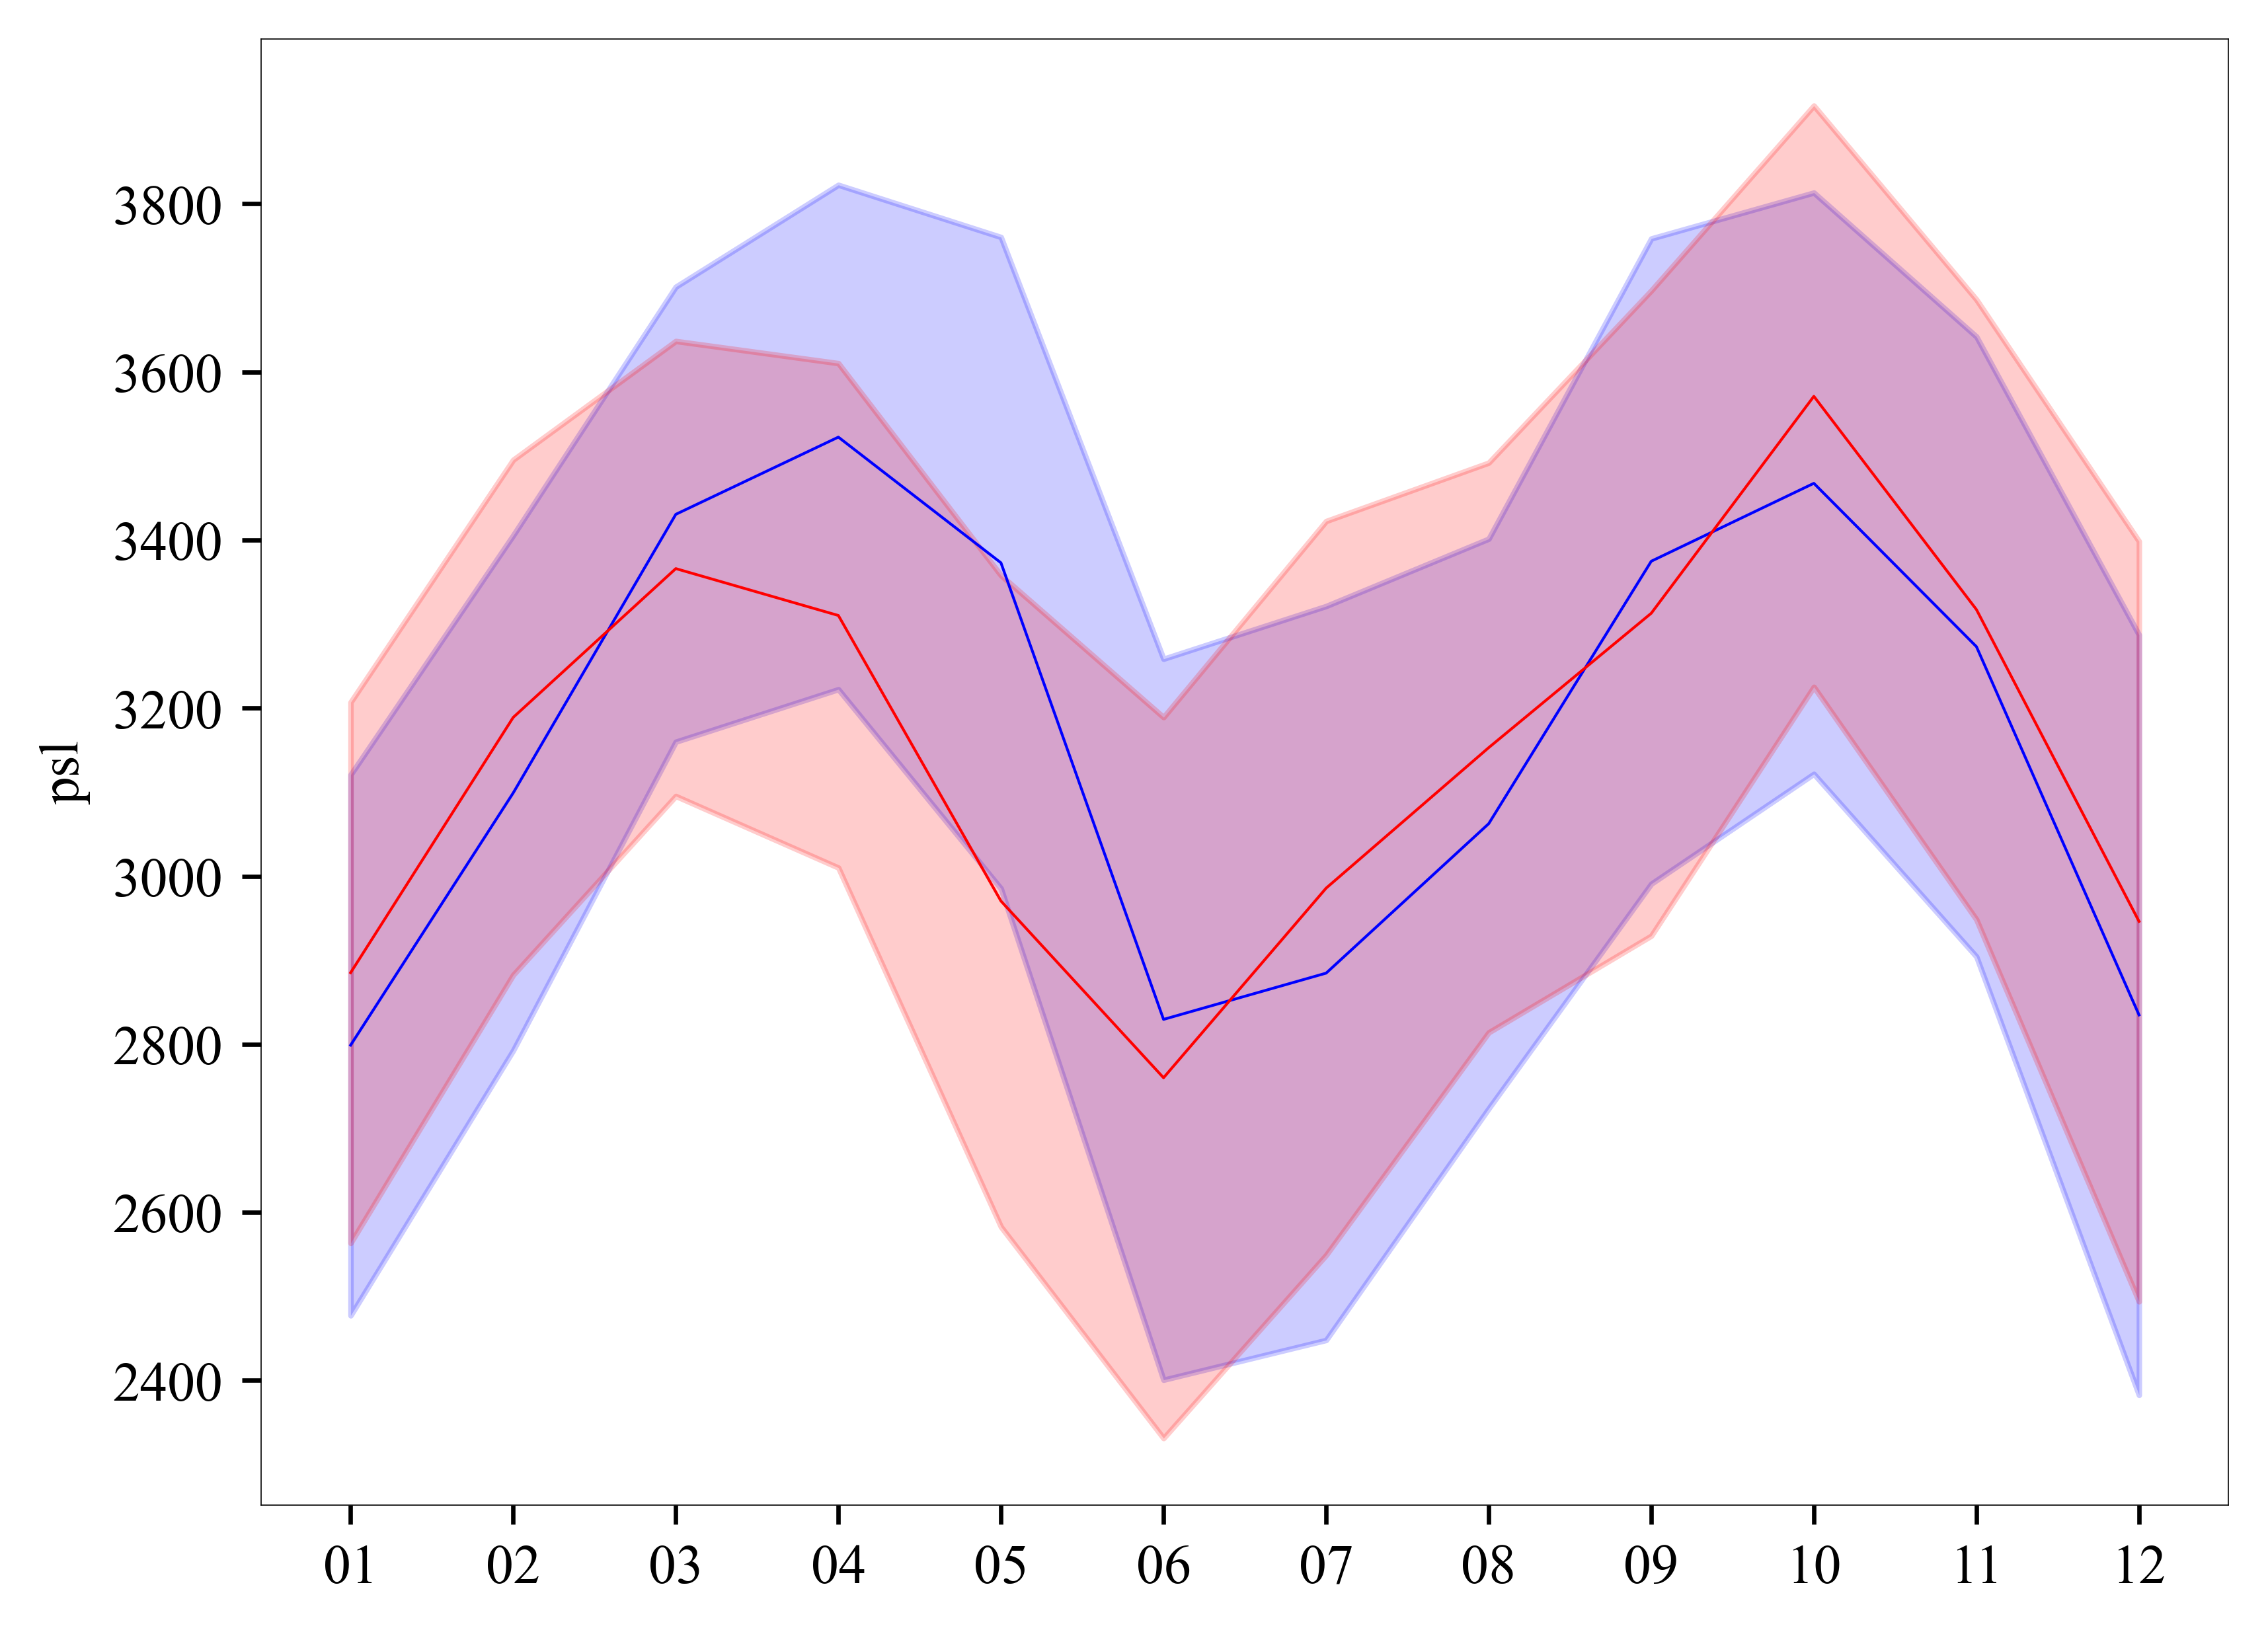

In [11]:
ax = sns.lineplot(
    x = months,
    y = mm_psl['sim_-40'] - mm_psl['sim_-65'],
    color='b', linewidth = 0.5,
)

sns.lineplot(
    x = months,
    y = mm_psl['era5_-40'] - mm_psl['era5_-65'],
    color='r', linewidth = 0.5,
)

ax.fill_between(
    x = months,
    y1 = mm_psl['sim_-40'] - mm_psl['sim_-65'] - mon_psl_diff_std,
    y2 = mm_psl['sim_-40'] - mm_psl['sim_-65'] + mon_psl_diff_std,
    color='b', alpha=0.2,
)

ax.fill_between(
    x = months,
    y1 = mm_psl['era5_-40'] - mm_psl['era5_-65'] - mon_psl_diff_std,
    y2 = mm_psl['era5_-40'] - mm_psl['era5_-65'] + mon_psl_diff_std,
    color='r', alpha=0.2,
)


In [21]:

print(psl_zh[expid[i]]['psl']['am'].sel(lat=-40, method='nearest').mean(dim='lon').values)
print(psl_zh[expid[i]]['psl']['am'].sel(lat=-65, method='nearest').mean(dim='lon').values)
print(psl_era5_79_21_alltime['am'].sel(latitude=-40, method='nearest').mean(dim='longitude').values)
print(psl_era5_79_21_alltime['am'].sel(latitude=-65, method='nearest').mean(dim='longitude').values)


101603.5389341173
98441.48656491702
101618.08798825099
98471.51407698003


# SAM trend

In [22]:
import pymannkendall as mk

mk_test = mk.original_test(sam_marshall.to_numpy().flatten())
print(mk_test)

time = pd.date_range(start='1/1/1957', end='12/1/2022', freq='M')

Mann_Kendall_Test(trend='increasing', h=True, p=8.840657095277038e-10, z=6.129047793949854, Tau=0.1456064267311047, s=45494.0, var_s=55093852.0, slope=0.0017127071823204417, intercept=-0.5165193370165744)


In [23]:
mk_test01_22 = mk.original_test(sam_marshall.iloc[44:66].to_numpy().flatten()[:-1])

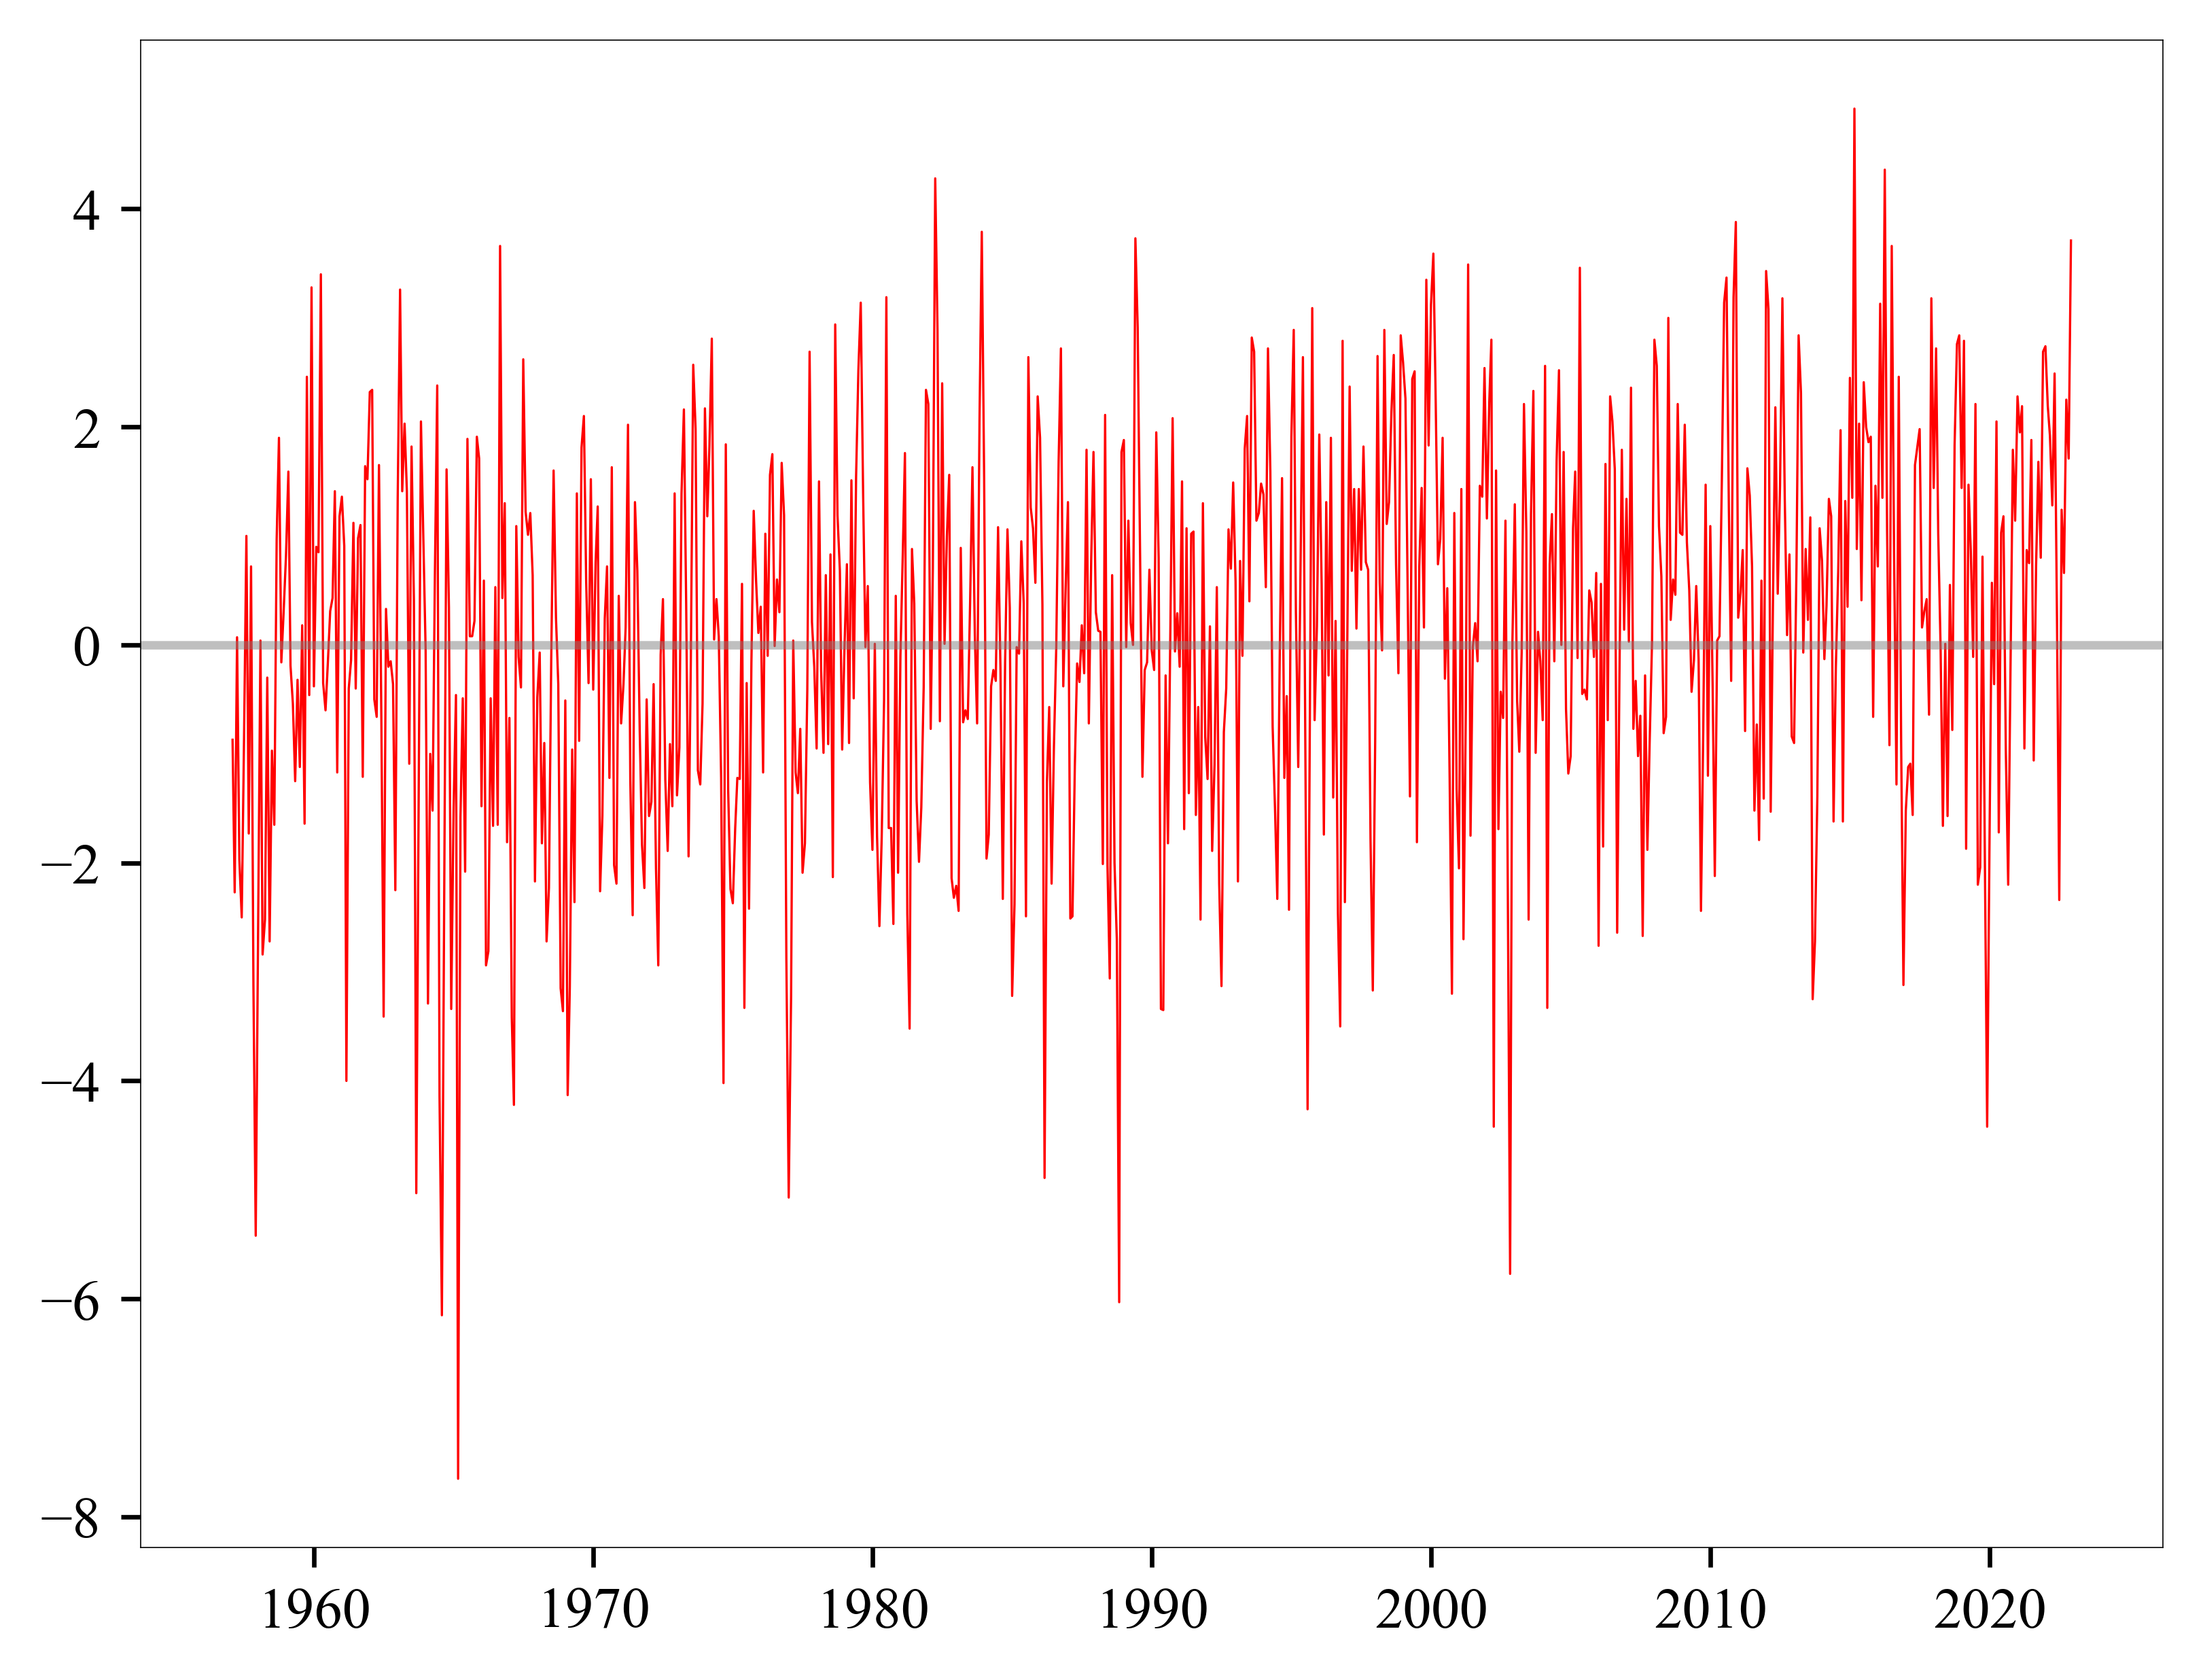

In [6]:
ax = sns.lineplot(
    x = time,
    y = sam_marshall.to_numpy().flatten()[:-1], color = 'r', lw = 0.4)

ax.axhline(y = 0, color = 'gray', alpha = 0.5)

# ax.axline((0, mk_test.intercept), slope = mk_test.slope, color = 'b', lw = 0.5)



# ax.axline((0, mk_test01_22.intercept), slope = mk_test01_22.slope, color = 'k', lw = 0.5)

In [ ]:
fit = np.polyfit(time, sam_marshall.to_numpy().flatten()[:-1], deg=1)




fit = np.polyfit(time, sam_marshall.to_numpy().flatten()[:-1], deg=1)
print ("Slope : " + str(fit[0]))
print ("Intercept : " + str(fit[1]))


In [8]:
from numpy.polynomial.polynomial import Polynomial

Polynomial.fit(
    x = np.arange(0, len(sam_marshall.to_numpy().flatten()[:-1]), 1),
    y = sam_marshall.to_numpy().flatten()[:-1],
    deg = 1
)

Polynomial([0.07939317, 0.68369086], domain=[  0., 790.], window=[-1.,  1.])